In [1]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [12]:
import pandas as pd
import numpy as np
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt

In [3]:
TARGET_NAME = 'units'

In [4]:
def get_score(y_true, y_predict):
    return math.sqrt(mean_squared_error(y_true, y_predict))

#### Считывание данных

In [5]:
key = pd.read_csv("kaggle/walmart-recruiting-sales-in-stormy-weather/key.csv")
train = pd.read_csv("kaggle/walmart-recruiting-sales-in-stormy-weather/train.csv")
test = pd.read_csv("kaggle/walmart-recruiting-sales-in-stormy-weather/test.csv")
weather = pd.read_csv("kaggle/walmart-recruiting-sales-in-stormy-weather/weather.csv")

#### Описание данных

#### Предобработка данных

In [6]:
def convert_to_minutes(x):
    x.loc[x == "-"] = np.nan
    x.loc[~x.isnull()] = (x[~x.isnull()].astype(int) % 100) + (x[~x.isnull()].astype(int) // 100 * 60)

#### Предобработка данных

In [7]:
def preprocessing(data, key, weather, target_field=TARGET_NAME):
    data = data.join(key.set_index("store_nbr"), on="store_nbr")
    data = data.join(weather.set_index(["station_nbr", "date"]), on=["station_nbr", "date"])
    
    convert_to_minutes(data['sunrise'])
    convert_to_minutes(data['sunset'])
    
    mlb = MultiLabelBinarizer()
    codesum_data = pd.DataFrame(mlb.fit_transform(weather['codesum'].str.split()),columns=mlb.classes_)
    for c in codesum_data.columns:
        if len(c) < 4:
            continue
        for sub_c in [c[:2], c[2:]]:
            codesum_data.loc[:, sub_c] = codesum_data[c] + (codesum_data[sub_c]) if sub_c in codesum_data.columns else 0
        codesum_data.drop(columns=c, inplace=True)
    
    data.drop(columns=["codesum"], inplace=True)
    data = data.join(codesum_data.sort_index(axis=1))
    
    data.fillna(-1, inplace=True)

    needed_columns = ["store_nbr", "item_nbr"]
    if target_field in data.columns:
        needed_columns.append(target_field)
    data = data[needed_columns]
    data = pd.get_dummies(data, columns=["store_nbr", "item_nbr"])
    if target_field in data.columns:
        data.loc[:, target_field] = np.log(data[target_field] + 1)
        
    return data

In [8]:
preprocessed_train = preprocessing(train, key, weather)
preprocessed_test = preprocessing(test, key, weather)

train_columns = preprocessed_train.columns
test_columns = preprocessed_test.columns
diff_columns = list(set(train_columns) - set(test_columns))
diff_columns.remove(TARGET_NAME)
print("Diff of columns {}". format(diff_columns))
for column in diff_columns:
    preprocessed_test.loc[column] = 0 # Add missing field after onehot encoding

/Users/skrrydg/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Diff of columns ['store_nbr_35']


#### Кросвалидация 

In [59]:
y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

samples = np.random.choice(X.shape[0], 100000, replace=False)
X = X.iloc[samples]
y = y.iloc[samples]

depths = []
test_score = []
train_score = []

for depth in range(5, 30, 10):
    model = RandomForestRegressor(criterion='mse', n_estimators=100, max_depth=depth)
    cv_results = cross_validate(model, X, y, cv=3, return_train_score=True, scoring='neg_mean_squared_error')
    depths.append(depth)
    test_score.append(-np.mean(cv_results['test_score']))
    train_score.append(-np.mean(cv_results['train_score']))


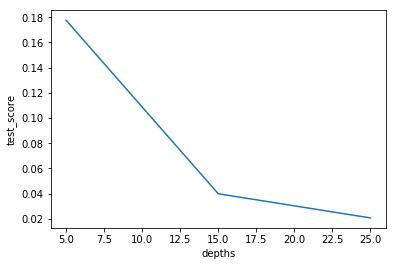

In [60]:
plt.plot(depths, test_score)
plt.ylabel('test_score')
plt.xlabel('depths')
plt.show()

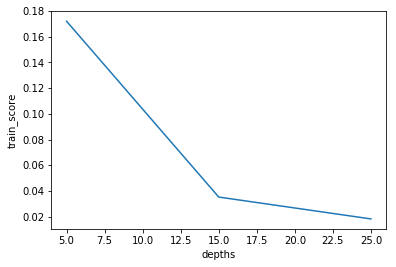

In [61]:
plt.plot(depths, train_score)
plt.ylabel('train_score')
plt.xlabel('depths')
plt.show()

#### Обучение базовой модели

In [63]:
y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

In [64]:
model = RandomForestRegressor(criterion='mse', n_estimators=100, max_depth=25)

In [ ]:
model.fit(X, y)

#### Предсказание

In [ ]:
y_predict = model.predict(preprocessed_test)
y_predict = np.exp(y_predict) - 1

In [ ]:
_id = (test["store_nbr"].astype("str") + "_" + test["item_nbr"].astype("str") + "_" + test["date"].astype('str')).to_numpy()
_units = np.round(y_predict).astype(int)

In [ ]:
prediction = pd.DataFrame(data={"id": _id, "units": _units}).set_index("id") 
prediction.to_csv("kaggle/walmart-recruiting-sales-in-stormy-weather/submissions/benchmark1.csv")